<a href="https://colab.research.google.com/github/Tea-Yeon-Kim/AI-Class/blob/main/week7/BP_data_classfication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

In [70]:
import requests

url = "https://raw.githubusercontent.com/MyungKyuYi/AI-class/refs/heads/main/BP_data.csv"
response = requests.get(url)

with open('BP_data.csv', 'wb') as file:
    file.write(response.content)

# LabelEncoder 객체 생성
label_encoder = LabelEncoder()

data = pd.read_csv(url, index_col=0)
data

,Blood_Pressure_Abnormality,Level_of_Hemoglobin,Genetic_Pedigree_Coefficient,Age,BMI,Sex,Pregnancy,Smoking,Physical_activity,salt_content_in_the_diet,alcohol_consumption_per_day,Level_of_Stress,Chronic_kidney_disease,Adrenal_and_thyroid_disorders
Patient_Number,,,,,,,,,,,,,,
1,1,11.28,0.90,34,23,1,1.0,0,45961,48071,NaN,2,1,1
2,0,9.75,0.23,54,33,1,NaN,0,26106,25333,205.0,3,0,0
3,1,10.79,0.91,70,49,0,NaN,0,9995,29465,67.0,2,1,0
4,0,11.00,0.43,71,50,0,NaN,0,10635,7439,242.0,1,1,0
5,1,14.17,0.83,52,19,0,NaN,0,15619,49644,397.0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,1,10.14,0.02,69,26,1,NaN,1,26118,47568,144.0,3,1,0
1997,1,11.77,1.00,24,45,1,1.0,1,2572,8063,NaN,3,1,1
1998,1,16.91,0.22,18,42,0,NaN,0,14933,24753,NaN,2,1,1


In [71]:
data.columns

Index(['Blood_Pressure_Abnormality', 'Level_of_Hemoglobin',
       'Genetic_Pedigree_Coefficient', 'Age', 'BMI', 'Sex', 'Pregnancy',
       'Smoking', 'Physical_activity', 'salt_content_in_the_diet',
       'alcohol_consumption_per_day', 'Level_of_Stress',
       'Chronic_kidney_disease', 'Adrenal_and_thyroid_disorders'],
      dtype='object')

In [72]:
# 결측치 확인
missing_values = data.isnull().sum()

print("\n결측치 개수:")
print(missing_values)


결측치 개수:
Blood_Pressure_Abnormality          0
Level_of_Hemoglobin                 0
Genetic_Pedigree_Coefficient       92
Age                                 0
BMI                                 0
Sex                                 0
Pregnancy                        1558
Smoking                             0
Physical_activity                   0
salt_content_in_the_diet            0
alcohol_consumption_per_day       242
Level_of_Stress                     0
Chronic_kidney_disease              0
Adrenal_and_thyroid_disorders       0
dtype: int64


In [73]:
# 1. Genetic_Pedigree_Coefficient
data['Genetic_Pedigree_Coefficient'] = data['Genetic_Pedigree_Coefficient'].fillna(
    data['Genetic_Pedigree_Coefficient'].median()
)

# 2. Pregnancy (성별 기반 처리)
data.drop(columns=['Pregnancy'], inplace=True)

# 3. alcohol_consumption_per_day (결측 여부 + 중앙값 대체)
data['alcohol_na'] = data['alcohol_consumption_per_day'].isna().astype(int)

data['alcohol_consumption_per_day'] = data['alcohol_consumption_per_day'].fillna(
    data['alcohol_consumption_per_day'].median()
)


In [74]:
# 결측치 확인
missing_values = data.isnull().sum()

print("\n결측치 개수:")
print(missing_values)


결측치 개수:
Blood_Pressure_Abnormality       0
Level_of_Hemoglobin              0
Genetic_Pedigree_Coefficient     0
Age                              0
BMI                              0
Sex                              0
Smoking                          0
Physical_activity                0
salt_content_in_the_diet         0
alcohol_consumption_per_day      0
Level_of_Stress                  0
Chronic_kidney_disease           0
Adrenal_and_thyroid_disorders    0
alcohol_na                       0
dtype: int64


In [75]:
# 데이터와 타겟 분리
X = data.drop('Blood_Pressure_Abnormality', axis=1).values
y = data['Blood_Pressure_Abnormality'].values

In [76]:
# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [77]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape,

((1600, 13), (400, 13), (1600,), (400,))

In [78]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

In [79]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1600, 13]),
 torch.Size([400, 13]),
 torch.Size([1600]),
 torch.Size([400]))

In [82]:
class BP_data_Dense(nn.Module):
    def __init__(self):
        super(BP_data_Dense, self).__init__()
        self.fc1 = nn.Linear(13, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = BP_data_Dense()

In [83]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [84]:
# Variables to store loss and accuracy
train_losses = []
test_accuracies = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    train_losses.append(running_loss / len(train_dataloader))

    # Evaluate on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/20, Loss: 0.6567, Accuracy: 71.50%
Epoch 2/20, Loss: 0.5600, Accuracy: 74.50%
Epoch 3/20, Loss: 0.5056, Accuracy: 78.25%
Epoch 4/20, Loss: 0.4763, Accuracy: 79.75%
Epoch 5/20, Loss: 0.4434, Accuracy: 81.25%
Epoch 6/20, Loss: 0.4136, Accuracy: 83.50%
Epoch 7/20, Loss: 0.3797, Accuracy: 85.50%
Epoch 8/20, Loss: 0.3567, Accuracy: 88.25%
Epoch 9/20, Loss: 0.3258, Accuracy: 89.50%
Epoch 10/20, Loss: 0.3087, Accuracy: 90.25%
Epoch 11/20, Loss: 0.2961, Accuracy: 90.50%
Epoch 12/20, Loss: 0.2878, Accuracy: 90.50%
Epoch 13/20, Loss: 0.2794, Accuracy: 89.25%
Epoch 14/20, Loss: 0.2705, Accuracy: 89.75%
Epoch 15/20, Loss: 0.2642, Accuracy: 91.25%
Epoch 16/20, Loss: 0.2593, Accuracy: 90.50%
Epoch 17/20, Loss: 0.2576, Accuracy: 90.00%
Epoch 18/20, Loss: 0.2499, Accuracy: 90.50%
Epoch 19/20, Loss: 0.2439, Accuracy: 89.75%
Epoch 20/20, Loss: 0.2438, Accuracy: 90.50%
Training complete.


In [85]:
# Evaluation
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

# Calculate specificity for each class
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[190  18]
 [ 20 172]]
F1 Score: 0.90
Precision: 0.91
Recall: 0.91
Specificity: 0.90


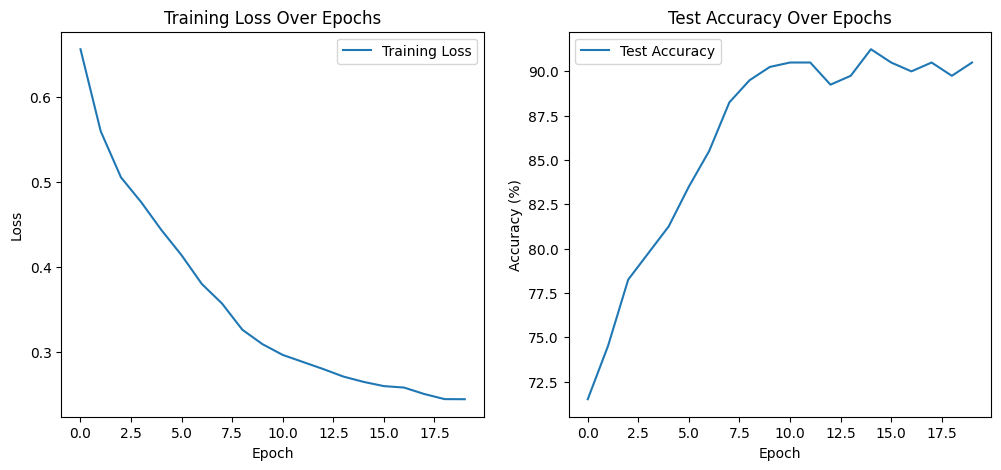

In [86]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()